In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### 1. 모든 단어 사용

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수 : 46
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


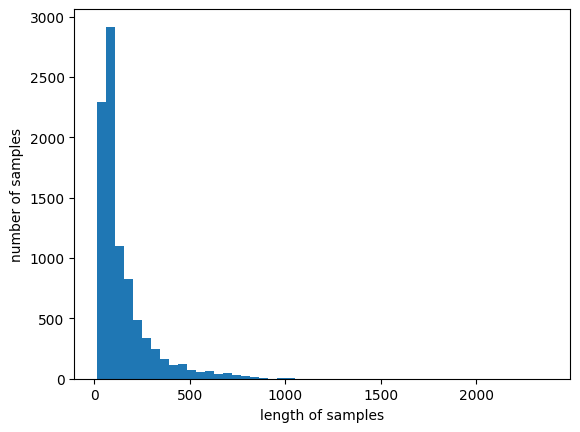

In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

# 분류 클래스 수 확인
num_classes = max(y_train + 1)
print('클래스의 수 : {}'.format(num_classes))

# 데이터 분포 확인
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

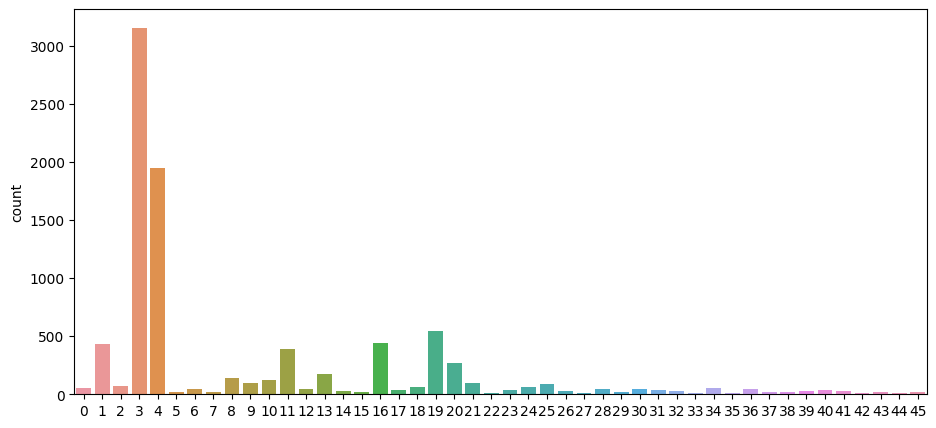

In [4]:
# 클래스 별 데이터 분포 확인
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

데이터 분포가 매우 __불균일_ 하므로, __정확도__ 만을 성능 평가 지표로 삼기에는 무리가 있음. 이에 __recall, precision, f1-score__ 을 함께 사용함.

In [5]:
# index_to_word 딕셔너리 생성
word_index = reuters.get_word_index(path='reuters_word_index.json')
index_to_word = {index+3: word for word, index in word_index.items()}

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(('<pad>','<sos>','<unk>')):
    index_to_word[index]=token
    
# 원본 데이터로 디코딩
# train 데이터
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print('train data 개수: ', len(x_train))

# test 데이터
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print('test data 개수: ',len(x_test))

train data 개수:  8982
test data 개수:  2246


In [6]:
# 벡터화 하기
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# DTM 생성 및 크기 확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print('train data의 DTM 크기: ', x_train_dtm.shape)

# train data로 TF-IDF 생성 및 크기 확인
tfidf_transformer = TfidfTransformer()
tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)
print('train data의 TF-IDF크기: ',tfidfv_train.shape)

# test data로 TF-IDF 생성 및 크기 확인
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
print('test data의 DTM 크기: ', x_test_dtm.shape)
print('test data의 TF-IDF크기: ',tfidfv_test.shape)

train data의 DTM 크기:  (8982, 26506)
train data의 TF-IDF크기:  (8982, 26506)
test data의 DTM 크기:  (2246, 26506)
test data의 TF-IDF크기:  (2246, 26506)


__다양한 머신러닝 모델로 학습 및 테스트 해보기__

In [7]:
# 머신러닝 모델 호출
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC

# metric 호출
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score)

# 그 외 필요한 모듈 호출
from collections import defaultdict
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

In [8]:
nb = MultinomialNB()
cb = ComplementNB()
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
forest = RandomForestClassifier(n_estimators=5, random_state=0)
grbt = GradientBoostingClassifier(random_state=0)
voting = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft')


clf_list = [(nb, 'MultinomialNB'),(cb, 'ComplementNB'),
             (lr, 'LogisticRegression'),(lsvc, 'LinearSVC'),
             (tree, 'DecisionTree'),(forest, 'RandomForest'),
             (grbt, 'GradientBoosting'),(voting,'Voting')]

In [11]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(tfidfv_train, y_train)
    #y_prob = clf.predict_proba(tfidfv_test)
    y_pred = clf.predict(tfidfv_test)
    scores['Classifier'].append(name)
    
    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred, average='macro', zero_division=0))
        
    score_df = pd.DataFrame(scores).set_index('Classifier')
    score_df.round(decimals=3)
    
score_df

C:\ProgramData\anaconda3\envs\mecab\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Precision,Recall,F1
Classifier,,,
MultinomialNB,0.091999,0.068328,0.067679
ComplementNB,0.618473,0.416823,0.463985
LogisticRegression,0.794707,0.635267,0.670408
LinearSVC,0.695535,0.628461,0.638290
DecisionTree,0.220003,0.145197,0.154501
RandomForest,0.398685,0.252052,0.279463
GradientBoosting,0.623057,0.569655,0.573434
Voting,0.726628,0.643615,0.648340


In [9]:
scores_acc = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(tfidfv_train, y_train)
    #y_prob = clf.predict_proba(tfidfv_test)
    y_pred = clf.predict(tfidfv_test)
    scores_acc['Classifier'].append(name)
    
    score_name = accuracy_score.__name__.replace("_", " ").replace("score", "").capitalize()
    scores_acc[score_name].append(accuracy_score(y_test, y_pred))
    
    score_acc_df = pd.DataFrame(scores_acc).set_index('Classifier')
    score_acc_df.round(decimals=3)

score_acc_df

C:\ProgramData\anaconda3\envs\mecab\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Accuracy
Classifier,
MultinomialNB,0.599733
ComplementNB,0.764915
LogisticRegression,0.816118
LinearSVC,0.792965
DecisionTree,0.621104
RandomForest,0.654497
GradientBoosting,0.769813
Voting,0.816118


In [12]:
scores_None = pd.concat([score_df, score_acc_df], axis=1)
scores_None

,Precision,Recall,F1,Accuracy
Classifier,,,,
MultinomialNB,0.091999,0.068328,0.067679,0.599733
ComplementNB,0.618473,0.416823,0.463985,0.764915
LogisticRegression,0.794707,0.635267,0.670408,0.816118
LinearSVC,0.695535,0.628461,0.638290,0.792965
DecisionTree,0.220003,0.145197,0.154501,0.621104
RandomForest,0.398685,0.252052,0.279463,0.654497
GradientBoosting,0.623057,0.569655,0.573434,0.769813
Voting,0.726628,0.643615,0.648340,0.816118


### 2. 빈도수 상위 5,000개의 단어만 사용

In [13]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [14]:
# index_to_word 딕셔너리 생성
word_index = reuters.get_word_index(path='reuters_word_index.json')
index_to_word = {index+3: word for word, index in word_index.items()}

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(('<pad>','<sos>','<unk>')):
    index_to_word[index]=token
    
# 원본 데이터로 디코딩
# train 데이터
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print('train data 개수: ', len(x_train))

# test 데이터
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print('test data 개수: ',len(x_test))

train data 개수:  8982
test data 개수:  2246


In [15]:
# 벡터화 하기
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# DTM 생성 및 크기 확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print('train data의 DTM 크기: ', x_train_dtm.shape)

# train data로 TF-IDF 생성 및 크기 확인
tfidf_transformer = TfidfTransformer()
tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)
print('train data의 TF-IDF크기: ',tfidfv_train.shape)

# test data로 TF-IDF 생성 및 크기 확인
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
print('test data의 DTM 크기: ', x_test_dtm.shape)
print('test data의 TF-IDF크기: ',tfidfv_test.shape)

train data의 DTM 크기:  (8982, 4867)
train data의 TF-IDF크기:  (8982, 4867)
test data의 DTM 크기:  (2246, 4867)
test data의 TF-IDF크기:  (2246, 4867)


In [16]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(tfidfv_train, y_train)
    #y_prob = clf.predict_proba(tfidfv_test)
    y_pred = clf.predict(tfidfv_test)
    scores['Classifier'].append(name)
    
    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred, average='macro', zero_division=0))
        
    score_df = pd.DataFrame(scores).set_index('Classifier')
    score_df.round(decimals=3)
    
score_df

C:\ProgramData\anaconda3\envs\mecab\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Precision,Recall,F1
Classifier,,,
MultinomialNB,0.161560,0.118453,0.110173
ComplementNB,0.628640,0.439137,0.482035
LogisticRegression,0.745917,0.613240,0.650872
LinearSVC,0.678684,0.602094,0.616216
DecisionTree,0.237599,0.172272,0.177946
RandomForest,0.542921,0.311584,0.359609
GradientBoosting,0.602493,0.588703,0.579038
Voting,0.710820,0.641304,0.653499


In [17]:
scores_acc = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(tfidfv_train, y_train)
    #y_prob = clf.predict_proba(tfidfv_test)
    y_pred = clf.predict(tfidfv_test)
    scores_acc['Classifier'].append(name)
    
    score_name = accuracy_score.__name__.replace("_", " ").replace("score", "").capitalize()
    scores_acc[score_name].append(accuracy_score(y_test, y_pred))
    
    score_acc_df = pd.DataFrame(scores_acc).set_index('Classifier')
    score_acc_df.round(decimals=3)

score_acc_df

C:\ProgramData\anaconda3\envs\mecab\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Accuracy
Classifier,
MultinomialNB,0.673197
ComplementNB,0.770703
LogisticRegression,0.803651
LinearSVC,0.774711
DecisionTree,0.617988
RandomForest,0.701247
GradientBoosting,0.767142
Voting,0.809884


In [18]:
scores_5000 = pd.concat([score_df, score_acc_df], axis=1)
scores_5000

,Precision,Recall,F1,Accuracy
Classifier,,,,
MultinomialNB,0.161560,0.118453,0.110173,0.673197
ComplementNB,0.628640,0.439137,0.482035,0.770703
LogisticRegression,0.745917,0.613240,0.650872,0.803651
LinearSVC,0.678684,0.602094,0.616216,0.774711
DecisionTree,0.237599,0.172272,0.177946,0.617988
RandomForest,0.542921,0.311584,0.359609,0.701247
GradientBoosting,0.602493,0.588703,0.579038,0.767142
Voting,0.710820,0.641304,0.653499,0.809884


In [19]:
scores_None

,Precision,Recall,F1,Accuracy
Classifier,,,,
MultinomialNB,0.091999,0.068328,0.067679,0.599733
ComplementNB,0.618473,0.416823,0.463985,0.764915
LogisticRegression,0.794707,0.635267,0.670408,0.816118
LinearSVC,0.695535,0.628461,0.638290,0.792965
DecisionTree,0.220003,0.145197,0.154501,0.621104
RandomForest,0.398685,0.252052,0.279463,0.654497
GradientBoosting,0.623057,0.569655,0.573434,0.769813
Voting,0.726628,0.643615,0.648340,0.816118


모든 단어를 사용했을 때와 단어 개수를 5000개로 제한했을 때 모두 Logistic Regression과 Voting 방식의 F1-score가 가장 높음.

Logistic regression은 단어 개수에 제한을 두지 않았을 때 더 높은 f1 score값을 가지며, Voting 방식은 단어 개수를 5000개로 제한했을 때 더 높은 f1 score 값을 가짐.

### 3. 직접 단어 개수를 설정해서 사용(num_words=10000)

In [20]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

In [21]:
# index_to_word 딕셔너리 생성
word_index = reuters.get_word_index(path='reuters_word_index.json')
index_to_word = {index+3: word for word, index in word_index.items()}

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(('<pad>','<sos>','<unk>')):
    index_to_word[index]=token
    
# 원본 데이터로 디코딩
# train 데이터
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print('train data 개수: ', len(x_train))

# test 데이터
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print('test data 개수: ',len(x_test))

train data 개수:  8982
test data 개수:  2246


In [22]:
# 벡터화 하기
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# DTM 생성 및 크기 확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print('train data의 DTM 크기: ', x_train_dtm.shape)

# train data로 TF-IDF 생성 및 크기 확인
tfidf_transformer = TfidfTransformer()
tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)
print('train data의 TF-IDF크기: ',tfidfv_train.shape)

# test data로 TF-IDF 생성 및 크기 확인
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
print('test data의 DTM 크기: ', x_test_dtm.shape)
print('test data의 TF-IDF크기: ',tfidfv_test.shape)

train data의 DTM 크기:  (8982, 9670)
train data의 TF-IDF크기:  (8982, 9670)
test data의 DTM 크기:  (2246, 9670)
test data의 TF-IDF크기:  (2246, 9670)


In [23]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(tfidfv_train, y_train)
    #y_prob = clf.predict_proba(tfidfv_test)
    y_pred = clf.predict(tfidfv_test)
    scores['Classifier'].append(name)
    
    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred, average='macro', zero_division=0))
        
    score_df = pd.DataFrame(scores).set_index('Classifier')
    score_df.round(decimals=3)
    
score_df

C:\ProgramData\anaconda3\envs\mecab\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Precision,Recall,F1
Classifier,,,
MultinomialNB,0.171376,0.101931,0.096728
ComplementNB,0.625071,0.439243,0.478358
LogisticRegression,0.773326,0.626985,0.662544
LinearSVC,0.704261,0.616591,0.636619
DecisionTree,0.230360,0.176134,0.184053
RandomForest,0.456775,0.268326,0.309318
GradientBoosting,0.626723,0.585051,0.578270
Voting,0.725839,0.647123,0.651254


In [24]:
scores_acc = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(tfidfv_train, y_train)
    #y_prob = clf.predict_proba(tfidfv_test)
    y_pred = clf.predict(tfidfv_test)
    scores_acc['Classifier'].append(name)
    
    score_name = accuracy_score.__name__.replace("_", " ").replace("score", "").capitalize()
    scores_acc[score_name].append(accuracy_score(y_test, y_pred))
    
    score_acc_df = pd.DataFrame(scores_acc).set_index('Classifier')
    score_acc_df.round(decimals=3)

score_acc_df

C:\ProgramData\anaconda3\envs\mecab\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Accuracy
Classifier,
MultinomialNB,0.656723
ComplementNB,0.770703
LogisticRegression,0.810329
LinearSVC,0.780944
DecisionTree,0.620214
RandomForest,0.674087
GradientBoosting,0.766696
Voting,0.816563


In [25]:
scores_10000 = pd.concat([score_df, score_acc_df], axis=1)
scores_10000

,Precision,Recall,F1,Accuracy
Classifier,,,,
MultinomialNB,0.171376,0.101931,0.096728,0.656723
ComplementNB,0.625071,0.439243,0.478358,0.770703
LogisticRegression,0.773326,0.626985,0.662544,0.810329
LinearSVC,0.704261,0.616591,0.636619,0.780944
DecisionTree,0.230360,0.176134,0.184053,0.620214
RandomForest,0.456775,0.268326,0.309318,0.674087
GradientBoosting,0.626723,0.585051,0.578270,0.766696
Voting,0.725839,0.647123,0.651254,0.816563


In [48]:
scores_5000

,Precision,Recall,F1,Accuracy
Classifier,,,,
MultinomialNB,0.161560,0.118453,0.110173,0.673197
ComplementNB,0.628640,0.439137,0.482035,0.770703
LogisticRegression,0.745917,0.613240,0.650872,0.803651
LinearSVC,0.678684,0.602094,0.616216,0.774711
DecisionTree,0.237599,0.172272,0.177946,0.617988
RandomForest,0.542921,0.311584,0.359609,0.701247
GradientBoosting,0.602493,0.588703,0.579038,0.767142
Voting,0.710820,0.641304,0.653499,0.809884


In [49]:
scores_None

,Precision,Recall,F1,Accuracy
Classifier,,,,
MultinomialNB,0.091999,0.068328,0.067679,0.599733
ComplementNB,0.618473,0.416823,0.463985,0.764915
LogisticRegression,0.794707,0.635267,0.670408,0.816118
LinearSVC,0.695535,0.628461,0.638290,0.792965
DecisionTree,0.220003,0.145197,0.154501,0.621104
RandomForest,0.398685,0.252052,0.279463,0.654497
GradientBoosting,0.623057,0.569655,0.573434,0.769813
Voting,0.726628,0.643615,0.648340,0.816118


### 4. 딥러닝 모델과 비교해 보기 (LSTM 사용)

* 공정한 비교를 위해 이때 Word2Vec 등의 pretrained model은 사용하지 않음.

단어 수에 제한을 두지 않았을 때의 LogisticRegression 모델의 F1-score가 가장 높게 나왔으므로, 동일한 데이터셋을 사용해 LSTM에 적용시켜봄

In [70]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [71]:
# index_to_word 딕셔너리 생성
word_index = reuters.get_word_index(path='reuters_word_index.json')
index_to_word = {index+3: word for word, index in word_index.items()}

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(('<pad>','<sos>','<unk>')):
    index_to_word[index]=token
    
# 원본 데이터로 디코딩
# train 데이터
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print('train data 개수: ', len(x_train))

# test 데이터
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print('test data 개수: ',len(x_test))

train data 개수:  8982
test data 개수:  2246


In [72]:
# 벡터화 하기
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# DTM 생성 및 크기 확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print('train data의 DTM 크기: ', x_train_dtm.shape)

# train data로 TF-IDF 생성 및 크기 확인
tfidf_transformer = TfidfTransformer()
tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)
print('train data의 TF-IDF크기: ',tfidfv_train.shape)

# test data로 TF-IDF 생성 및 크기 확인
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
print('test data의 DTM 크기: ', x_test_dtm.shape)
print('test data의 TF-IDF크기: ',tfidfv_test.shape)

train data의 DTM 크기:  (8982, 26506)
train data의 TF-IDF크기:  (8982, 26506)
test data의 DTM 크기:  (2246, 26506)
test data의 TF-IDF크기:  (2246, 26506)


In [75]:
from keras.preprocessing import sequence

x_train = sequence.pad_sequences(tfidfv_train.toarray(), maxlen=100)
x_test = sequence.pad_sequences(tfidfv_test.toarray(), maxlen=100)

In [76]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(y_train)
one_hot_test_labels = to_categorical(y_test)

In [83]:
model_rnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
epochs=20

In [79]:
# 1000개 샘플은 검증 세트로 사용
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [84]:
history = model_rnn.fit(partial_x_train, partial_y_train, epochs=epochs, 
                        batch_size=128, validation_data = (x_val, y_val))

Epoch 1/20
63/63 [==============================] - 9s 25ms/step - loss: 2.8152 - accuracy: 0.3401 - val_loss: 2.4029 - val_accuracy: 0.3540
Epoch 2/20
63/63 [==============================] - 1s 14ms/step - loss: 2.4168 - accuracy: 0.3514 - val_loss: 2.3981 - val_accuracy: 0.3540
Epoch 3/20
63/63 [==============================] - 1s 14ms/step - loss: 2.4145 - accuracy: 0.3514 - val_loss: 2.3984 - val_accuracy: 0.3540
Epoch 4/20
63/63 [==============================] - 1s 14ms/step - loss: 2.4129 - accuracy: 0.3514 - val_loss: 2.3969 - val_accuracy: 0.3540
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 2.4126 - accuracy: 0.3514 - val_loss: 2.4017 - val_accuracy: 0.3540
Epoch 6/20
63/63 [==============================] - 1s 14ms/step - loss: 2.4114 - accuracy: 0.3514 - val_loss: 2.3919 - val_accuracy: 0.3540
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 2.4115 - accuracy: 0.3514 - val_loss: 2.3931 - val_accuracy: 0.3540
Epoch 8/20
63

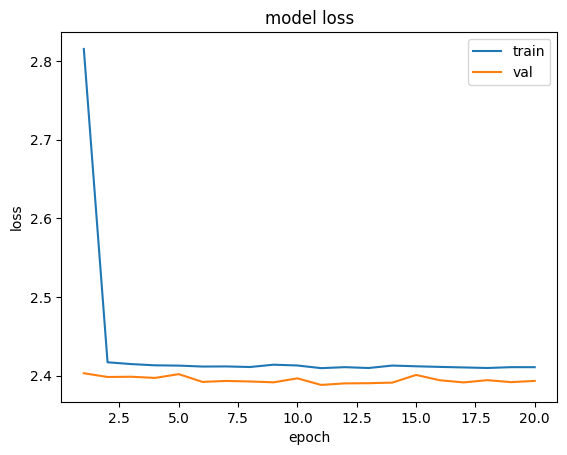

In [89]:
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [85]:
results = model_rnn.evaluate(x_test,  one_hot_test_labels, verbose=2)

print(results)

71/71 - 1s - loss: 2.4215 - accuracy: 0.3620
[2.4215073585510254, 0.36197686195373535]


1. TF-IDF는 각 문서에 등장한 단어의 빈도수를 기반으로 중요도를 산출하며, 0~1 사이의 값을 가짐. 사용한 모델 중 'Logistic regression'과 'linearSVC'는 feature scaling에 민감한 모델이라 TF-IDF로 벡터화된 data의 패턴을 학습하기 유리함. 때문에 단어 개수와 무관하게 비교적 높은 수준의 성능을 보임.<br>
    * __Logistic regression과 linearSVC이 feature scaling에 민감함 이유?__
    * 상기 두 모델은 L1 또는 L2 정규화와 같은 정규화 기술을 사용함. feature의 scale이 다른 경우 이러한 정규화 항은 과적합을 방지하기 위해 일부 feature에 더 큰 가중치 penalty를 부여함. 각 fiture의 스케일을 비슷하게 맞추면 특정 feature가 정규화 프로세스의 지배를 받지 않도록 함.
    * Distance Metrics: 상기 두 모델은 거리 기반 최적화 알고리즘(예: 경사 하강법)을 사용하여 최적의 가중치를 찾음. 유클리드 거리 또는 내적과 같은 Distance Metrics는 feature 스케일에 민감함. 스케일이 다른 경우 distance 계산을 통한 최적화 프로세스 과정에 기여하는 정도가 불균일함.
    * 결정 경계: 로지스틱 회귀 및 linearSVC 모델은 데이터 포인트를 분류하기 위해 결정 경계의 개념에 의존함. 결정 경계는 사실상 선형으로 feature space에서 직선 또는 초평면으로 표현됨. feature scale이 다른 경우 특정 차원을 따라 확장된 결정 경계로 이어질 수 있으므로 이러한 모델이 복잡한 패턴을 학습하고 캡처하기가 어려움. feature를 rescaling하면 데이터를 정렬하고 feature space에서 보다 균형 잡힌 표현을 달성하는 데 도움이 됨.
    * __multinomialNB, complementNB, decision tree, and random forest는 feature scaling에 덜 민감한 이유?__
    * MultinomialNB: multinomialNB를 포함한 Naive Bayes 모델은 확률을 기반으로 하며 주어진 클래스와 feature가 독립적이라고 가정함. Feature scaling은 독립성 가정에 영향을 주지 않으며 모델의 성능에 큰 영향을 주지 않음.
    * ComplementNB: ComplementNB는 multinomialNB이 불균일한 dataset에 취약하다는 점을 보완하기 위해 개발된 모델임. 스케일링이 어느 정도 영향을 미칠 수 있지만 일반적으로 이 모델에서는 덜 중요함.
    * Decision Tree and Random Forest: feature 및 threshold 값을 사용한 데이터의 계층적 분할을 기반으로 함. 분할 기준은 피처의 절대값이 아닌 상대적인 순서를 기반으로 하기 때문에 피처 스케일링에 민감하지 않음. 특히나 위 프로젝트에서 사용한 Decision tree의 max_depths는 10으로 설정되어 있음. 46개의 불균일한 클래스를 분류하기에는 한계가 있음.<br>
<br>
2. logistic regression, complementNB, gradient boosting 모델로 구성된 VotingClassifier가 비교적 우수한 성능을 보인이유?
    * logistic regression은 위에서 봤듯, feature의 scale에 민감하기 때문에 TF-IDF 방식으로 벡터화된 data의 패턴을 학습하기 유리하다는 것을 알았음.
    * ComplementNB는 불균형한 dataset을 handling하기 위해 multinomialNB에서 개선된 베이지안 이론 기반 모델임.
    * gradient boosting은 ensemble model 중 하나로, data간의 복잡한 관계성을 파악할 때 우수함. 규제를 적용하기 때문에 과적합에 robust해서 범용성이 우수함.
    * 위와 같은 특성들로 인해 위 세 가지 모델을 합친 Voting model이 우수한 성능을 보였다고 생각함.<br>
<br>
3. Deeplearning model인 LSTM이 machine learning model보다 안좋은 성능을 보인 이유는?
    * 불충분한 데이터: 딥 러닝 모델은 범용성 달성을 위해 다양성을 갖는 대량의 훈련 데이터가 필요하나 사용한 데이터셋은 약 8천개밖에 안되며 매우 불균일한 데이터 분포를 보임. 이에 모델이 복잡한 패턴을 캡처하고 효과적으로 일반화하는 데 어려움을 겪은 것으로 보임.
    * 하이퍼파라미터 조정: 딥 러닝 모델에는 최적의 성능을 위해 신중하게 조정해야 하는 많은 하이퍼파라미터가 있음 (학습 속도, 배치 크기, LSTM 단위 수, 임베딩 차원 등). 다양한 하이퍼파라미터를 실험하고 모델 최적화를 수행하여 LSTM 모델의 성능을 향상시킬 수 있을 것으로 보이나, 학습 데이터 개수와 다양성이 부족해 개선 정도가 크지 않을 것이라 예상됨.
    * 불충분한 훈련 시간: 딥 러닝 모델은 종종 기존 기계 학습 모델에 비해 더 긴 교육 시간이 필요함. LSTM 모델이 제한된 수의 에포크 동안 훈련되었거나 훈련이 조기에 중단된 경우 모델이 완전한 학습 잠재력에 도달하지 못했을 수 있음. 학습 에포크 수를 늘리고 모델이 데이터의 패턴을 학습하는 데 더 많은 시간을 허용하면 잠재적으로 성능이 향상될 수 있으나, 20 epoch를 실험했을 때 train 과 validation set 모두 일정 loss에 수렴한 이후 큰 변동성을 보이지 않고 있음. 이는 모델 구조, 하이퍼파라미터, 데이터셋의 특성 등이 문제인것으로 보임.
    * 클래스 불균형: LSTM 모델을 교육하는 데 사용되는 데이터 세트에 특정 클래스의 샘플 수가 훨씬 적은 불균형 클래스 분포가 있는 경우 모델의 성능에 부정적인 영향을 미칠 수 있음. LSTM을 포함한 딥 러닝 모델은 불균형 데이터에 민감할 수 있으며 소수 클래스를 정확하게 예측하는 데 어려움을 겪을 수 있음. 이러한 경우 오버샘플링, 언더샘플링 또는 클래스 가중치 조정과 같은 기술을 적용하여 클래스 불균형 문제를 해결하고 성능을 개선해야 함.<br>
<br>
4. 딥 러닝 모델의 성능은 특정 데이터 세트, 모델 구성, 하이퍼파라미터에 따라 크게 달라질 수 있기 때문에 모든 경우의 데이터에서 기존 머신 러닝 모델을 항상 능가하는 것은 아님을 알 수 있었음. 주어진 작업에 대해 최상의 결과를 얻기 위해 다양한 모델, feature representation 및 하이퍼파라미터를 철저히 분석하고 실험해야 할 듯 함.

__Ref__

* https://scikit-learn.org/stable/modules/model_evaluation.html

* https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

* https://stackoverflow.com/questions/52269187/facing-valueerror-target-is-multiclass-but-average-binary